CODE BY: Amitrajit Bose

CODE FROM: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

COMMENTS BY: KUBA Jerzmanowski
class CustomSGD: By Kuba Jerzmanowski



In [68]:
#jsut block of code with imports
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

In [69]:
#this line is a pre processing step for the data. We turn the data into tensors and then normalize the inputs.
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]) 

#these lines just import the data as torch Dataset
trainset = datasets.MNIST('/Users/kuba/Documents/Data/Datasets', download=True, train=True, transform=transform)
valset = datasets.MNIST('/Users/kuba/Documents/Data/Datasets', download=True, train=False, transform=transform)

# These lines create the "dataloader" which is just an iterator wrapped around the Dataset.
# This is necessary if you want to train with batches as we are doing
# Note: training with batches incurs other benefits (possibly better convergence) that are not just
# because we can't fit the whole dataset into memory at once
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [70]:
#here the aouther of the code made of variable but to make def the model easyer later
#but these coudl have also been hardcoded
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Here we define the structure of our model. It's a Feedforward network.
# We use the values from before, but the structure of our network is an MLP with 2 hidden layers.
# We use ReLU nonlinearity and softmax on the output layer to turn the logits into prediction probabilities.
# (Not fully true we use log softmax since its more numerically safe but you can apply e^y to get the true prediction values)
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

In [71]:
import torch

class CustomSGD:
    def __init__(self, params, lr=0.003, momentum=0.9):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.delta = [torch.zeros_like(param) for param in self.params]

    def zero_grad(self):
        #set all grads to zero
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue

                #new delta is currect grad + momentum term time old delta
                self.delta[i] = self.momentum * self.delta[i] + param.grad
                param -= self.lr * self.delta[i]

In [72]:
# we define the loss metric we are using with will ne negative log-likelihood 
criterion = nn.NLLLoss()

# our optimizers is now custom
optimizer = CustomSGD(model.parameters(), lr=0.003, momentum=0.9)

# def the num epochs to train for
epochs = 15

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(epochs):
    running_loss = 0
    running_f1 = 0 
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad() #clear grads
        output = model(images)
        loss = criterion(output, labels)
        
        loss.backward() #back prop grads
        optimizer.step() # setp (update weights)
        
        # We just save the loss value so we can show it later
        running_loss += loss.item()
        running_f1 += (f1_score(labels.tolist(), output.argmax(dim=1).tolist(), average='macro'))

    
    # calc average training loss and f1 for the epoch
    train_losses.append(running_loss / len(trainloader))
    train_f1_scores.append(running_f1 / len(trainloader))
    
    # eval on the validation set
    model.eval()
    running_val_loss = 0
    running_val_f1 = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(images.shape[0], -1)
            output = model(images)
            running_val_loss += criterion(output, labels).item()
            
            _, predicted = torch.max(output, 1)
            running_val_f1 += f1_score(labels.tolist(), predicted.tolist(), average='macro')

    
    # calc avg validation loss and f1 
    val_losses.append(running_val_loss / len(valloader))
    val_f1_scores.append(running_val_f1 / len(valloader))
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss / len(trainloader):.4f}, Train F1: {running_f1 / len(trainloader):.4f}, Val Loss: {running_val_loss / len(valloader):.4f}, Val F1: {running_val_f1 / len(valloader):.4f}")

Epoch [1/15], Train Loss: 0.6695, Train F1: 0.7777, Val Loss: 0.3225, Val F1: 0.8932
Epoch [2/15], Train Loss: 0.2953, Train F1: 0.9032, Val Loss: 0.2395, Val F1: 0.9216
Epoch [3/15], Train Loss: 0.2343, Train F1: 0.9234, Val Loss: 0.1954, Val F1: 0.9342
Epoch [4/15], Train Loss: 0.1876, Train F1: 0.9386, Val Loss: 0.1660, Val F1: 0.9458
Epoch [5/15], Train Loss: 0.1562, Train F1: 0.9484, Val Loss: 0.1375, Val F1: 0.9539
Epoch [6/15], Train Loss: 0.1315, Train F1: 0.9573, Val Loss: 0.1306, Val F1: 0.9558
Epoch [7/15], Train Loss: 0.1152, Train F1: 0.9627, Val Loss: 0.1160, Val F1: 0.9588
Epoch [8/15], Train Loss: 0.1022, Train F1: 0.9650, Val Loss: 0.1035, Val F1: 0.9654
Epoch [9/15], Train Loss: 0.0922, Train F1: 0.9694, Val Loss: 0.1007, Val F1: 0.9661
Epoch [10/15], Train Loss: 0.0828, Train F1: 0.9721, Val Loss: 0.0940, Val F1: 0.9667
Epoch [11/15], Train Loss: 0.0763, Train F1: 0.9734, Val Loss: 0.0960, Val F1: 0.9637
Epoch [12/15], Train Loss: 0.0686, Train F1: 0.9772, Val Loss: 

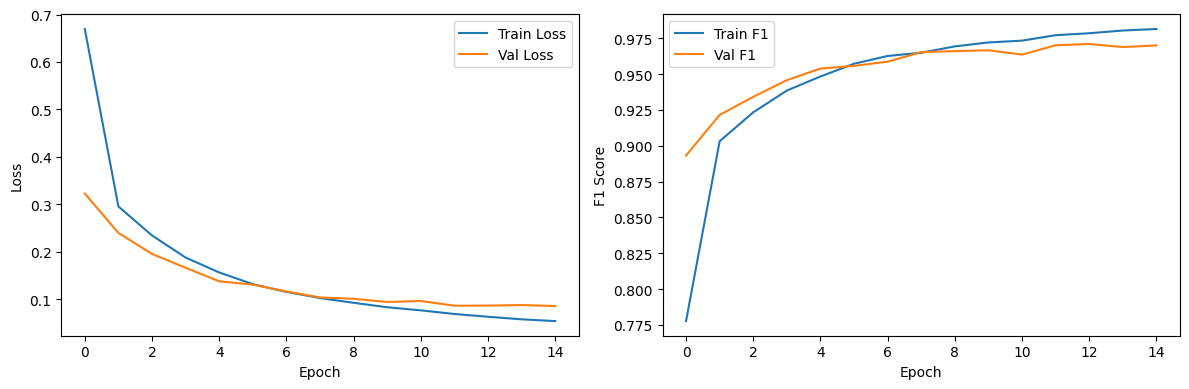

In [73]:

# plot the loss and f1 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1')
plt.plot(val_f1_scores, label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()